# Advanced Trading Applications

**From Regime Detection to Profitable Trading Strategies**

## Your Journey So Far

### Notebook 1: Mathematical Foundation
You learned **WHY** log returns are necessary:
- Stationarity, additivity, scale invariance
- Mathematical properties required for HMMs

### Notebook 2: HMM Mechanics  
You learned **HOW** HMMs work:
- Hidden states, transition matrices, emissions
- Viterbi and forward-backward algorithms

### Notebook 3: Production Pipeline
You learned to **DETECT** regimes:
- Pipeline setup and execution
- Regime classification and duration
- Model selection and validation

### Notebook 4: Trading Applications (This Notebook)
You'll learn to **TRADE** using regimes:
- Risk management by regime
- Technical indicator integration
- Position sizing and signal generation
- Backtesting and validation

---

## What This Notebook Covers

**Part A**: Regime-Specific Risk Analysis (Sections 1-2)
**Part B**: Technical Indicator Integration (Sections 3-4)
**Part C**: Portfolio Applications (Sections 5-6)
**Part D**: Backtesting & Validation (Sections 7-8)
**Part E**: Best Practices & Conclusion (Section 9)

---

## Prerequisites

Before starting this notebook:
- ✓ Completed Notebook 03
- ✓ Understand regime detection pipeline
- ✓ Familiar with confidence levels and regime characteristics

**Important**: This notebook demonstrates trading concepts for educational purposes. Always backtest thoroughly and start with paper trading before risking real capital.

---

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Add parent to path
sys.path.insert(0, str(Path().absolute().parent))

# Import hidden_regime
import hidden_regime as hr

# Plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette(sns.color_palette())

print(f"Imports complete")
print(f"hidden-regime version: {hr.__version__}")

Imports complete
hidden-regime version: 1.0.0


## Setup: Run Pipeline from Notebook 03

We'll reuse the same NVDA example to demonstrate trading applications.

In [2]:
# Create pipeline (same as Notebook 03)
ticker = 'NVDA'
n_states = 3

pipeline = hr.create_financial_pipeline(
    ticker=ticker,
    n_states=n_states,
    include_report=False
)

# Execute pipeline
report = pipeline.update()
result = pipeline.component_outputs['analysis']
raw_data = pipeline.data.get_all_data()

print(f"Pipeline complete: {len(result)} days analyzed")
print(f"Date range: {result.index[0].date()} to {result.index[-1].date()}")

Training on 500 observations (removed 0 NaN values)
Pipeline complete: 500 days analyzed
Date range: 2023-10-18 to 2025-10-15


# Part A: Regime-Specific Risk Analysis

## 1. Risk Metrics by Regime

Different regimes have different risk characteristics. Understanding these helps with:
- **Position sizing**: Larger positions in low-risk regimes
- **Stop-loss placement**: Wider stops in high-volatility regimes
- **Strategy selection**: Trend-following vs mean-reversion

### Key Risk Metrics

**Value at Risk (VaR)**: Maximum expected loss at confidence level $\alpha$

$$\text{VaR}_\alpha = -F^{-1}(\alpha)$$

where $F^{-1}$ is the inverse CDF of returns.

**Expected Shortfall (ES)**: Average loss beyond VaR

$$\text{ES}_\alpha = E[r \mid r \leq -\text{VaR}_\alpha]$$

**Sharpe Ratio**: Risk-adjusted return

$$\text{Sharpe} = \frac{\mu - r_f}{\sigma}$$

where $\mu$ is mean return, $r_f$ is risk-free rate, $\sigma$ is volatility.

**Maximum Drawdown**: Largest peak-to-trough decline

$$\text{MDD} = \max_{t} \left[ \frac{\max_{\tau \leq t} P_\tau - P_t}{\max_{\tau \leq t} P_\tau} \right]$$

In [3]:
# Get log returns aligned with regimes
log_return_col = next((col for col in raw_data.columns if col.lower() == 'log_return'), None)

if log_return_col is None:
    raise ValueError("Could not find log_return column")

# Calculate comprehensive risk metrics by regime
risk_metrics = {}

for regime in sorted(result['regime_name'].unique()):
    regime_data = result[result['regime_name'] == regime]
    regime_indices = regime_data.index
    regime_returns = raw_data.loc[regime_indices, log_return_col].dropna()
    
    if len(regime_returns) < 2:
        continue
    
    # Basic statistics
    mean_daily = regime_returns.mean()
    std_daily = regime_returns.std()
    mean_annual = mean_daily * 252
    std_annual = std_daily * np.sqrt(252)
    
    # Sharpe ratio (assuming 0% risk-free rate)
    sharpe = (mean_annual / std_annual) if std_annual > 0 else 0
    
    # Maximum drawdown
    cumulative = (1 + regime_returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Value at Risk
    var_95 = np.percentile(regime_returns, 5)
    var_99 = np.percentile(regime_returns, 1)
    
    # Expected Shortfall (Conditional VaR)
    es_95 = regime_returns[regime_returns <= var_95].mean()
    es_99 = regime_returns[regime_returns <= var_99].mean()
    
    # Win rate and profit factor
    wins = regime_returns[regime_returns > 0]
    losses = regime_returns[regime_returns < 0]
    win_rate = len(wins) / len(regime_returns) if len(regime_returns) > 0 else 0
    total_wins = wins.sum() if len(wins) > 0 else 0
    total_losses = abs(losses.sum()) if len(losses) > 0 else 0
    profit_factor = total_wins / total_losses if total_losses > 0 else float('inf')
    
    risk_metrics[regime] = {
        'days': len(regime_returns),
        'mean_daily': mean_daily * 100,
        'std_daily': std_daily * 100,
        'mean_annual': mean_annual * 100,
        'std_annual': std_annual * 100,
        'sharpe': sharpe,
        'max_drawdown': max_drawdown * 100,
        'var_95': var_95 * 100,
        'var_99': var_99 * 100,
        'es_95': es_95 * 100,
        'es_99': es_99 * 100,
        'win_rate': win_rate * 100,
        'profit_factor': profit_factor
    }

# Display risk metrics table
print("Risk Metrics by Regime")
print("=" * 100)
print(f"{'Regime':<12} {'Days':<8} {'Ann Return':<12} {'Ann Vol':<12} {'Sharpe':<10} {'Max DD':<12}")
print("-" * 100)

for regime in sorted(risk_metrics.keys()):
    m = risk_metrics[regime]
    print(f"{regime:<12} {m['days']:<8} {m['mean_annual']:>10.1f}% {m['std_annual']:>10.1f}% "
          f"{m['sharpe']:>9.2f} {m['max_drawdown']:>10.1f}%")

print("=" * 100)

Risk Metrics by Regime
Regime       Days     Ann Return   Ann Vol      Sharpe     Max DD      
----------------------------------------------------------------------------------------------------
Bear         97           -258.0%       68.4%     -3.77      -71.5%
Bull         110           657.7%       20.0%     32.91       -0.0%
Sideways     293           -39.1%       21.9%     -1.78      -44.1%


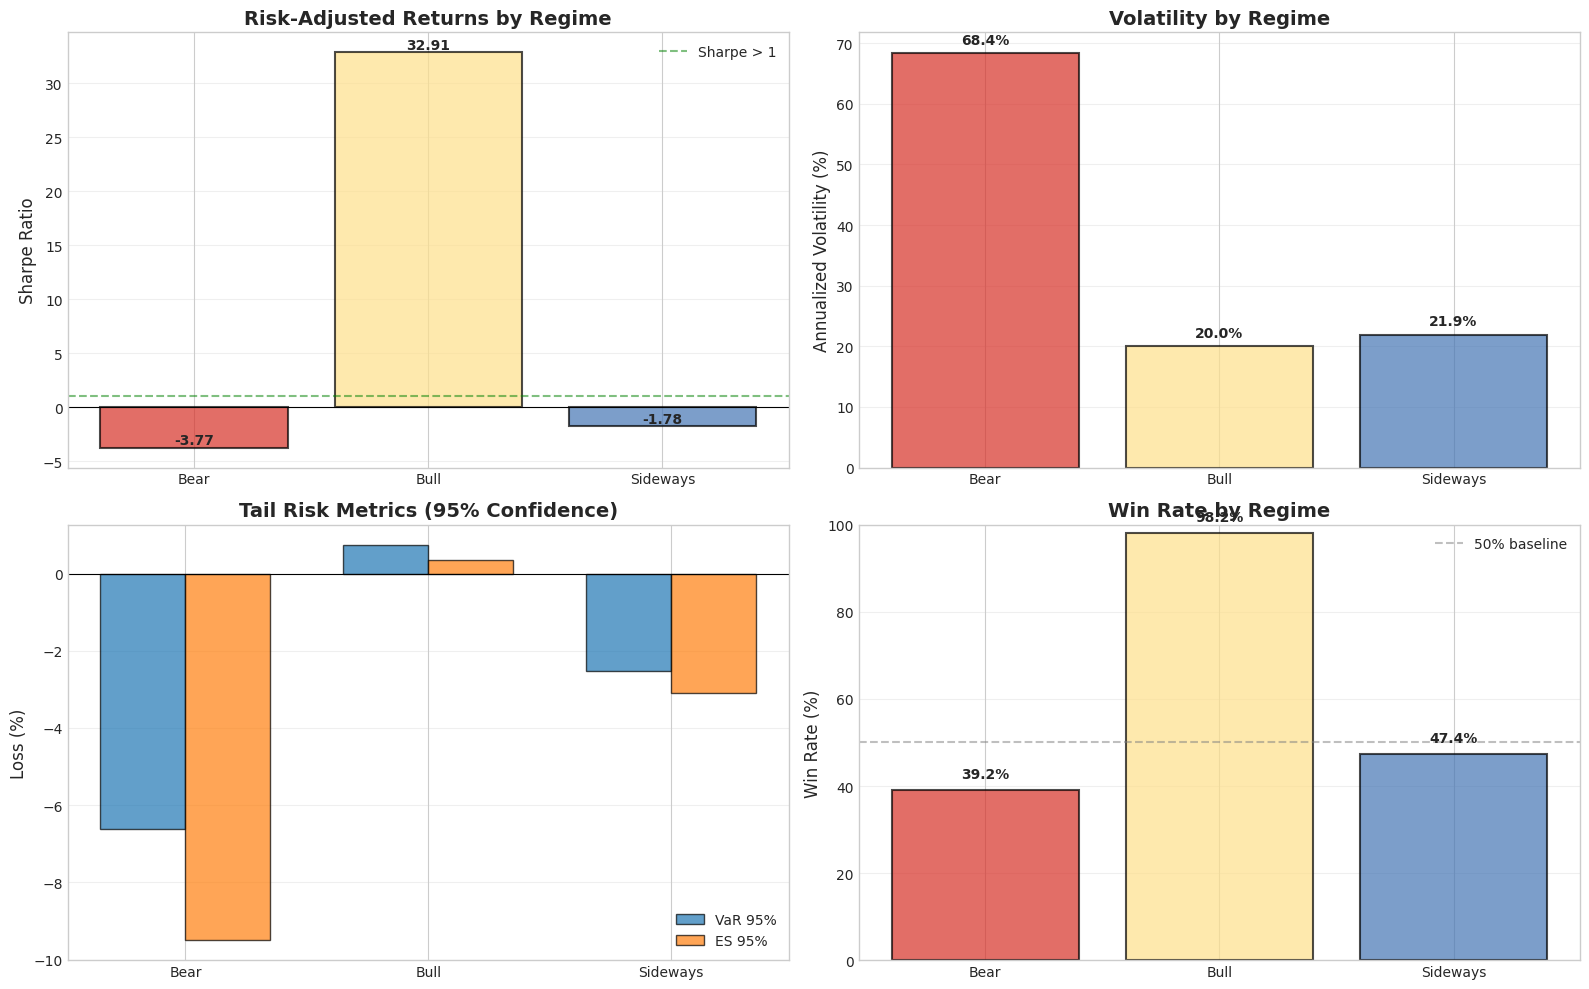

In [4]:
# Visualize risk metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Get regime colors
from hidden_regime.visualization import get_regime_colors
unique_regimes = sorted(risk_metrics.keys())
color_list = get_regime_colors(len(unique_regimes), color_scheme="colorblind_safe")
regime_colors = dict(zip(unique_regimes, color_list))

# 1. Sharpe Ratio comparison
ax = axes[0, 0]
regimes = list(risk_metrics.keys())
sharpes = [risk_metrics[r]['sharpe'] for r in regimes]
colors = [regime_colors[r] for r in regimes]

bars = ax.bar(regimes, sharpes, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Sharpe > 1')
ax.set_ylabel('Sharpe Ratio', fontsize=12)
ax.set_title('Risk-Adjusted Returns by Regime', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.legend()

# Add value labels
for bar, val in zip(bars, sharpes):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.05,
            f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

# 2. Volatility comparison
ax = axes[0, 1]
vols = [risk_metrics[r]['std_annual'] for r in regimes]
bars = ax.bar(regimes, vols, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Annualized Volatility (%)', fontsize=12)
ax.set_title('Volatility by Regime', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, vols):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1,
            f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')

# 3. VaR and ES comparison
ax = axes[1, 0]
x = np.arange(len(regimes))
width = 0.35

var_95_vals = [risk_metrics[r]['var_95'] for r in regimes]
es_95_vals = [risk_metrics[r]['es_95'] for r in regimes]

ax.bar(x - width/2, var_95_vals, width, label='VaR 95%', alpha=0.7, edgecolor='black')
ax.bar(x + width/2, es_95_vals, width, label='ES 95%', alpha=0.7, edgecolor='black')

ax.set_ylabel('Loss (%)', fontsize=12)
ax.set_title('Tail Risk Metrics (95% Confidence)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(regimes)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# 4. Win rate and profit factor
ax = axes[1, 1]
win_rates = [risk_metrics[r]['win_rate'] for r in regimes]

bars = ax.bar(regimes, win_rates, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='50% baseline')
ax.set_ylabel('Win Rate (%)', fontsize=12)
ax.set_title('Win Rate by Regime', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.legend()
ax.set_ylim(0, 100)

for bar, val in zip(bars, win_rates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 2,
            f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### Interpretation & Trading Implications

**Sharpe Ratio Analysis**:
- **Best regime**: Highest Sharpe ratio → allocate more capital
- **Sharpe > 1**: Excellent risk-adjusted returns
- **Sharpe < 0**: Losing money on average → avoid or short

**Volatility Management**:
- **High volatility regimes**: Use wider stop-losses, smaller positions
- **Low volatility regimes**: Can use tighter stops, larger positions
- Position size ∝ $\\frac{1}{\\sigma}$ (inverse volatility scaling)

**Tail Risk (VaR/ES)**:
- **Expected Shortfall > VaR**: Fat-tailed distribution, expect worse losses
- Use ES for position sizing: $\\text{Position\\ Size} = \\frac{\\text{Risk\\ Budget}}{|ES|}$

**Win Rate**:
- **High win rate**: Many small wins (mean-reversion strategy)
- **Low win rate**: Few large wins (trend-following strategy)
- Combine with profit factor for complete picture"


## 2. Dynamic Position Sizing

### Regime-Based Position Sizing Formula

Combine multiple risk factors to determine optimal position size:

$$\text{Position} = \text{Base} \times \underbrace{\frac{\sigma_{\text{target}}}{\sigma_{\text{regime}}}}_{\text{Vol Scaling}} \times \underbrace{\text{Confidence}}_{\text{Regime Certainty}} \times \underbrace{f(\text{Sharpe})}_{\text{Risk-Adjusted}}$$

Where:
- **Base**: Standard position size (e.g., 100% for full allocation)
- **Vol Scaling**: Adjust for regime volatility
- **Confidence**: Current regime probability from HMM
- **Risk-Adjusted**: Additional scaling based on Sharpe ratio

### Implementation Strategy

1. **Set target volatility**: $\sigma_{\text{target}} = 15\%$ (annual)
2. **Scale by regime volatility**: Position $\propto \frac{1}{\sigma_{\text{regime}}}$
3. **Apply confidence filter**: Reduce positions when confidence < 70%
4. **Apply regime quality filter**: Reduce positions in negative Sharpe regimes

In [5]:
# Calculate position sizing for each day
target_vol = 15.0  # Target 15% annualized volatility
position_sizes = []

for idx in result.index:
    current_regime = result.loc[idx, 'regime_name']
    confidence = result.loc[idx, 'confidence']
    
    # Get regime metrics
    regime_vol = risk_metrics[current_regime]['std_annual']
    regime_sharpe = risk_metrics[current_regime]['sharpe']
    
    # Base position (100% = full allocation)
    base_position = 1.0
    
    # Volatility scaling
    vol_scalar = target_vol / regime_vol if regime_vol > 0 else 0
    vol_scalar = min(vol_scalar, 2.0)  # Cap at 2x leverage
    
    # Confidence scaling
    conf_scalar = confidence if confidence > 0.6 else confidence * 0.5  # Penalize low confidence
    
    # Sharpe-based scaling
    if regime_sharpe > 1.0:
        sharpe_scalar = 1.0  # Full position
    elif regime_sharpe > 0.5:
        sharpe_scalar = 0.75  # Reduce position
    elif regime_sharpe > 0:
        sharpe_scalar = 0.5  # Half position
    else:
        sharpe_scalar = 0.0  # No position in negative Sharpe regimes
    
    # Combined position size
    final_position = base_position * vol_scalar * conf_scalar * sharpe_scalar
    final_position = max(0, min(final_position, 2.0))  # Clamp to [0, 2]
    
    position_sizes.append(final_position)

# Add to results (AFTER loop completes)
result['calculated_position_size'] = position_sizes

# Display summary
print("Position Sizing Summary")
print("=" * 80)
print(f"Target Volatility: {target_vol}%")
print(f"\nPosition Size Statistics:")
print(f"  Mean:   {np.mean(position_sizes):.2f}x")
print(f"  Median: {np.median(position_sizes):.2f}x")
print(f"  Min:    {np.min(position_sizes):.2f}x")
print(f"  Max:    {np.max(position_sizes):.2f}x")
print(f"\nBy Regime:")
for regime in sorted(result['regime_name'].unique()):
    regime_positions = result[result['regime_name'] == regime]['calculated_position_size']
    print(f"  {regime:<12} avg: {regime_positions.mean():.2f}x  (range: {regime_positions.min():.2f} - {regime_positions.max():.2f})")
print("=" * 80)

Position Sizing Summary
Target Volatility: 15.0%

Position Size Statistics:
  Mean:   0.11x
  Median: 0.00x
  Min:    0.00x
  Max:    0.73x

By Regime:
  Bear         avg: 0.00x  (range: 0.00 - 0.00)
  Bull         avg: 0.50x  (range: 0.16 - 0.73)
  Sideways     avg: 0.00x  (range: 0.00 - 0.00)


# Part B: Technical Indicator Integration

## 3. Understanding Technical Indicators

The pipeline automatically calculates classic technical indicators. Let's understand what they tell us and how they relate to regimes.

### The Four Indicators

**1. RSI (Relative Strength Index)**:
$$RSI = 100 - \frac{100}{1 + \frac{\text{Avg Gain}}{\text{Avg Loss}}}$$

- Range: 0-100
- > 70: Overbought (potential reversal down)
- < 30: Oversold (potential reversal up)
- Measures momentum

**2. MACD (Moving Average Convergence Divergence)**:
$$MACD = EMA_{12} - EMA_{26}$$
$$Signal = EMA_9(MACD)$$

- MACD > Signal: Bullish trend
- MACD < Signal: Bearish trend
- Trend-following indicator

**3. Bollinger Bands**:
$$\text{Upper} = SMA_{20} + 2\sigma$$
$$\text{Lower} = SMA_{20} - 2\sigma$$

- Price near upper band: Overbought
- Price near lower band: Oversold
- Measures volatility

**4. Moving Average**:
- Price > MA: Uptrend
- Price < MA: Downtrend
- Simple trend indicator

In [6]:
# Check indicator availability in result dataframe
indicator_cols = ['rsi_value', 'macd_value', 'bollinger_bands_value', 'moving_average_value',
                  'rsi_signal', 'macd_signal', 'bollinger_bands_signal', 'moving_average_signal',
                  'indicator_consensus', 'regime_consensus_agreement']

available_indicators = [col for col in indicator_cols if col in result.columns]

if len(available_indicators) > 0:
    print(f"Available indicators: {len(available_indicators)}/10")
    
    # Display current indicator status
    current = result.iloc[-1]
    
    print("\nCurrent Indicator Readings")
    print("=" * 80)
    
    indicators = [
        ('rsi', 'RSI'),
        ('macd', 'MACD'),
        ('bollinger_bands', 'Bollinger'),
        ('moving_average', 'Moving Avg')
    ]
    
    for ind_key, ind_name in indicators:
        value_col = f'{ind_key}_value'
        signal_col = f'{ind_key}_signal'
        
        if value_col in result.columns and signal_col in result.columns:
            value = current[value_col]
            signal = current[signal_col]
            signal_label = {1: "BULLISH", -1: "BEARISH", 0: "NEUTRAL"}.get(signal, "UNKNOWN")
            
            print(f"  {ind_name:<15} Value: {value:>8.2f}  Signal: {signal_label}")
    
    if 'indicator_consensus' in result.columns:
        consensus = current['indicator_consensus']
        print(f"\n  Consensus Score: {consensus:+.0f}/4")
        
        if consensus > 2:
            print("    Strong bullish agreement among indicators")
        elif consensus > 0:
            print("    Weak bullish lean")
        elif consensus < -2:
            print("    Strong bearish agreement among indicators")
        elif consensus < 0:
            print("    Weak bearish lean")
        else:
            print("    Mixed signals, no clear direction")
    
    print("=" * 80)
else:
    print("Note: Technical indicators not calculated in this pipeline run.")
    print("Indicators are available when using default pipeline configuration.")

Available indicators: 10/10

Current Indicator Readings
  RSI             Value:    52.34  Signal: NEUTRAL
  MACD            Value:    -0.70  Signal: BEARISH
  Bollinger       Value:     0.33  Signal: NEUTRAL
  Moving Avg      Value:    -0.02  Signal: BEARISH

  Consensus Score: -0/4
    Weak bearish lean


## 4. Regime-Indicator Agreement Analysis

### Why Agreement Matters
**High Agreement (>75%)**:
- Indicators confirm the regime
- Strong conviction for trading
- Both model-based and technical signals align

**Low Agreement (<25%)**:
- Indicators contradict the regime
- Potential regime transition
- Or indicator lag/divergence
- Caution warranted

### When to Trust Which Signal

| Scenario | Trust | Reasoning |
|----------|-------|----------|
| High confidence + High agreement | **Both** | Strong evidence from both approaches |
| High confidence + Low agreement | **HMM** | Regime clear, indicators lagging |
| Low confidence + High agreement | **Indicators** | Regime transition, indicators leading |
| Low confidence + Low agreement | **Neither** | Wait for clarity |"


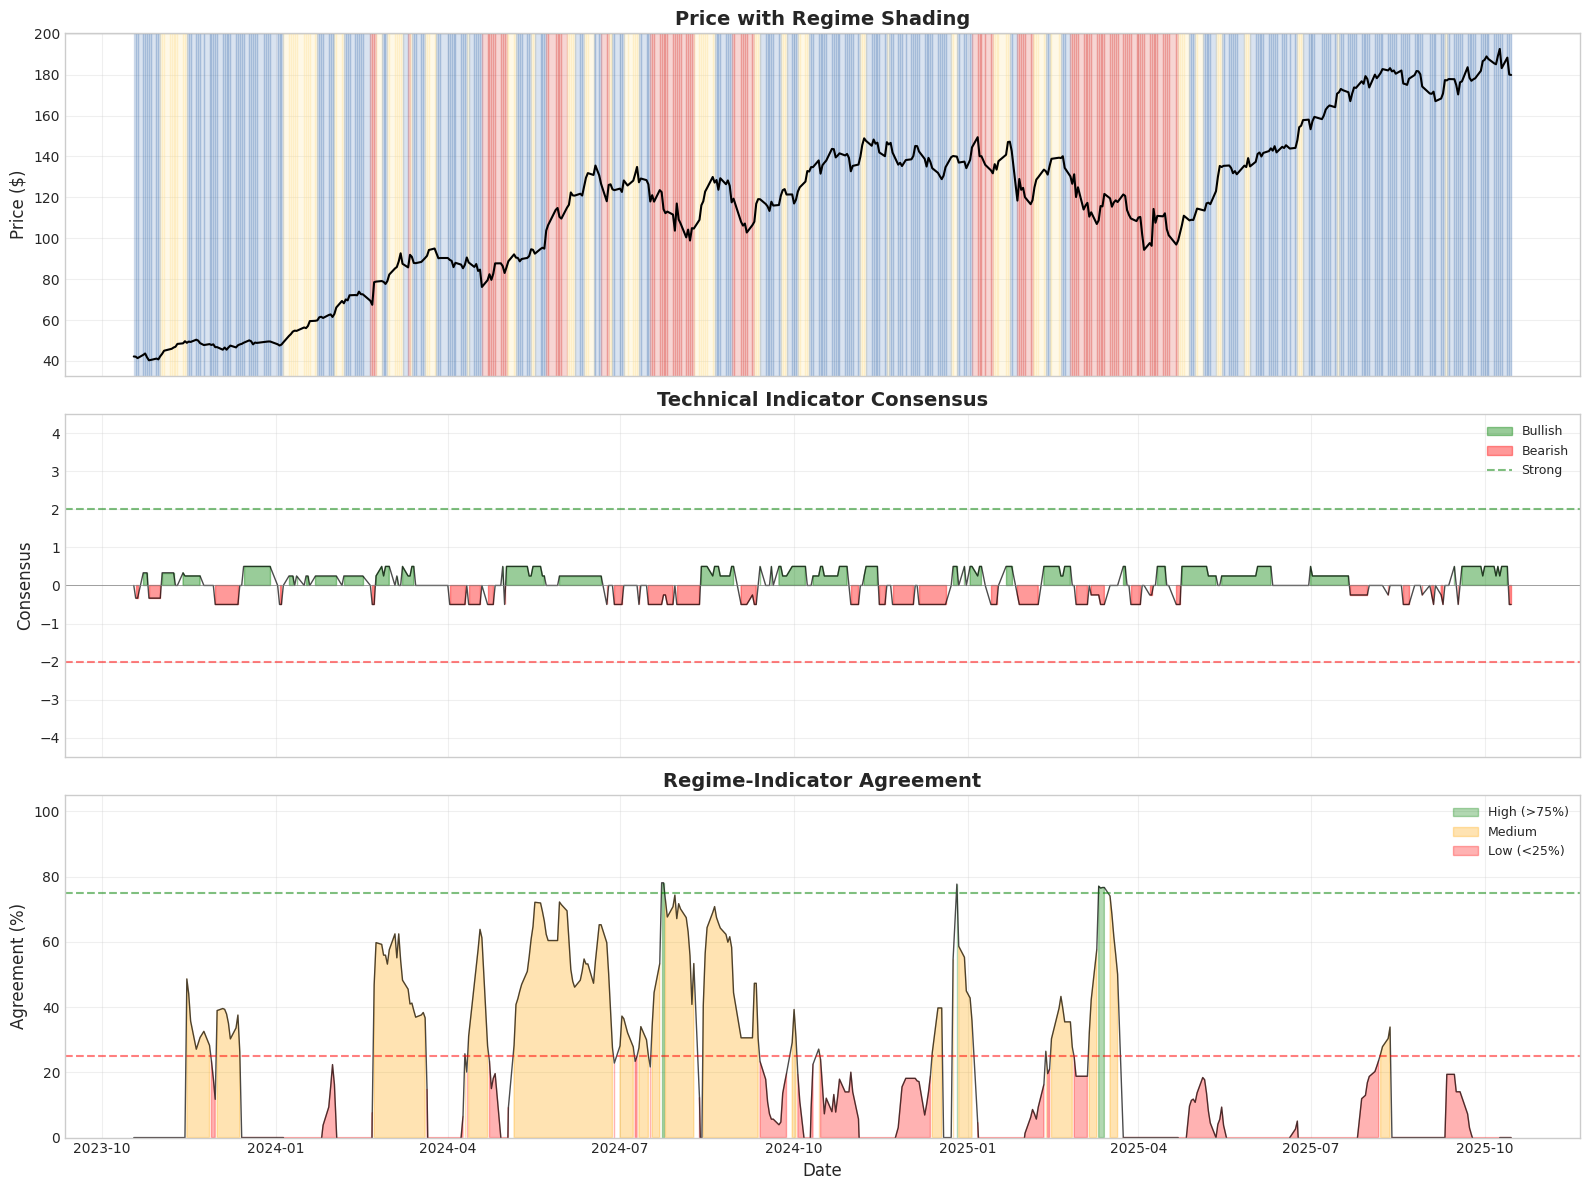


Agreement Statistics
  High Agreement (>75%):    7 days (1.4%)
  Low Agreement (<25%):   332 days (66.4%)
  Mixed (25-75%):         161 days (32.2%)


In [7]:
# Visualize indicator-regime relationship over time
if 'indicator_consensus' in result.columns and 'regime_consensus_agreement' in result.columns:
    fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
    
    # Get regime colors
    from hidden_regime.visualization import get_regime_colors
    unique_regimes = sorted(result['regime_name'].unique())
    color_list = get_regime_colors(len(unique_regimes), color_scheme="colorblind_safe")
    regime_colors = dict(zip(unique_regimes, color_list))
    
    # Panel 1: Price with regimes
    ax = axes[0]
    close_col = next((col for col in raw_data.columns if col.lower() == 'close'), None)
    if close_col:
        ax.plot(raw_data.index, raw_data[close_col], linewidth=1.5, color='black', zorder=2)
        
        # Shade by regime
        for i in range(len(result)):
            regime = result.iloc[i]['regime_name']
            color = regime_colors.get(regime, 'gray')
            ax.axvspan(result.index[i], result.index[min(i+1, len(result)-1)], 
                       alpha=0.2, color=color, zorder=1)
    
    ax.set_ylabel('Price ($)', fontsize=12)
    ax.set_title('Price with Regime Shading', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Panel 2: Indicator consensus
    ax = axes[1]
    consensus = result['indicator_consensus']
    
    ax.fill_between(result.index, 0, consensus, where=(consensus > 0), 
                    color='green', alpha=0.4, label='Bullish')
    ax.fill_between(result.index, 0, consensus, where=(consensus < 0),
                    color='red', alpha=0.4, label='Bearish')
    ax.plot(result.index, consensus, linewidth=1, color='black', alpha=0.7)
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    ax.axhline(y=2, color='green', linestyle='--', alpha=0.5, label='Strong')
    ax.axhline(y=-2, color='red', linestyle='--', alpha=0.5)
    
    ax.set_ylabel('Consensus', fontsize=12)
    ax.set_title('Technical Indicator Consensus', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=9)
    ax.set_ylim(-4.5, 4.5)
    
    # Panel 3: Agreement level
    ax = axes[2]
    agreement = result['regime_consensus_agreement'] * 100
    
    ax.fill_between(result.index, 0, agreement, where=(agreement > 75),
                    color='green', alpha=0.3, label='High (>75%)')
    ax.fill_between(result.index, 0, agreement, where=((agreement >= 25) & (agreement <= 75)),
                    color='orange', alpha=0.3, label='Medium')
    ax.fill_between(result.index, 0, agreement, where=(agreement < 25),
                    color='red', alpha=0.3, label='Low (<25%)')
    ax.plot(result.index, agreement, linewidth=1, color='black', alpha=0.7)
    
    ax.axhline(y=75, color='green', linestyle='--', alpha=0.5)
    ax.axhline(y=25, color='red', linestyle='--', alpha=0.5)
    
    ax.set_ylabel('Agreement (%)', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_title('Regime-Indicator Agreement', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=9)
    ax.set_ylim(0, 105)
    
    plt.tight_layout()
    plt.show()
    
    # Agreement statistics
    print("\nAgreement Statistics")
    print("=" * 80)
    high_agreement = (agreement > 75).sum()
    low_agreement = (agreement < 25).sum()
    total = len(agreement)
    
    print(f"  High Agreement (>75%): {high_agreement:>4} days ({high_agreement/total*100:.1f}%)")
    print(f"  Low Agreement (<25%):  {low_agreement:>4} days ({low_agreement/total*100:.1f}%)")
    print(f"  Mixed (25-75%):        {total-high_agreement-low_agreement:>4} days ({(total-high_agreement-low_agreement)/total*100:.1f}%)")
    print("=" * 80)
else:
    print("Indicator data not available for visualization.")

# Part C: Portfolio Applications

## 5. Trading Signal Generation

### Signal Types

The pipeline generates four types of position signals:

1. **LONG**: Enter or maintain long position
2. **SHORT**: Enter short position (if allowed)
3. **NEUTRAL**: Exit all positions, stay in cash
4. **REDUCE**: Decrease position size

### Signal Generation Logic

```python
if regime == "Bull" and confidence > 0.7:
    signal = "LONG"
elif regime == "Bear" and confidence > 0.7:
    signal = "SHORT"  # or "NEUTRAL" if shorting not allowed
elif confidence < 0.6:
    signal = "REDUCE"  # Low confidence
else:
    signal = "NEUTRAL"
```

### Signal Strength

Signal strength (0.0 to 1.0) determines position sizing:

$$\text{Strength} = f(\text{confidence}, \text{agreement}, \text{regime\_quality})$$

Where:
- **Confidence**: HMM regime probability
- **Agreement**: Indicator consensus alignment
- **Regime quality**: Based on Sharpe ratio

In [8]:
# Analyze current trading signal
def get_signal(regime, confidence):
    if regime == "Bull" and confidence > 0.7:
        signal = "LONG"
    elif regime == "Bear" and confidence > 0.7:
        signal = "SHORT"  # or "NEUTRAL" if shorting not allowed
    elif confidence < 0.6:
        signal = "REDUCE"  # Low confidence
    else:
        signal = "NEUTRAL"     
    return signal

if 'position_signal' in result.columns and 'signal_strength' in result.columns:
    current = result.iloc[-1]
    
    print("Current Trading Signal")
    print("=" * 80)
    print(f"  Date:           {result.index[-1].date()}")
    print(f"  Position:       {current['position_signal']}")
    print(f"  Strength:       {current['signal_strength']:.2f}")
    print(f"  Regime:         {current['regime_name']}")
    print(f"  Confidence:     {current['confidence']*100:.1f}%")
    
    if 'indicator_consensus' in result.columns:
        print(f"  Ind. Consensus: {current['indicator_consensus']:+.0f}")
    
    print("\n  RECOMMENDATION:")
    signal = get_signal(current['regime_name'], current['confidence'])
    if regime == "Bull" and confidence > 0.7:
        signal = "LONG"
    elif regime == "Bear" and confidence > 0.7:
        signal = "SHORT"  # or "NEUTRAL" if shorting not allowed
    elif confidence < 0.6:
        signal = "REDUCE"  # Low confidence
    else:
        signal = "NEUTRAL"    

    if signal == "LONG":
        position_pct = strength * 100
        print(f"    Take LONG position with {position_pct:.0f}% of normal size")
        if strength > 0.8:
            print("    High conviction trade")
        elif strength > 0.5:
            print("    Moderate conviction")
        else:
            print("    Low conviction - consider reducing exposure")
    elif signal == "SHORT":
        position_pct = strength * 100
        print(f"    Take SHORT position with {position_pct:.0f}% of normal size")
    elif signal == "NEUTRAL":
        print("    Stay in CASH - no clear opportunity")
    elif signal == "REDUCE":
        print("    REDUCE existing positions - regime uncertainty")
    
    print("=" * 80)
    
    # Signal distribution over time
    print("\nHistorical Signal Distribution")
    print("=" * 80)
    signal_counts = result['position_signal'].value_counts()
    total = len(result)

    signals = pd.Series(
        index=result.index, 
        data=[get_signal(result.loc[t].regime_name, result.loc[t].confidence) for t in result.index], 
        name='Signal')
    
    for signal_type in ['LONG', 'SHORT', 'NEUTRAL', 'REDUCE']:
        mask = signals == signal_type
        tmp = signals[mask]
        count = len(tmp)
        pct = len(tmp) / len(signals) * 100.0
        print(f"  {signal_type:<10} {count:>4} days ({pct:>5.1f}%)")
    
    print("=" * 80)
else:
    print("Position signals not available in pipeline output.")

Current Trading Signal
  Date:           2025-10-15
  Position:       0.005626293211470941
  Strength:       0.01
  Regime:         Sideways
  Confidence:     82.3%
  Ind. Consensus: -0

  RECOMMENDATION:
    Stay in CASH - no clear opportunity

Historical Signal Distribution
  LONG         61 days ( 12.2%)
  SHORT        74 days ( 14.8%)
  NEUTRAL     291 days ( 58.2%)
  REDUCE       74 days ( 14.8%)


## 6. Confidence-Weighted Position Sizing Example

### Real-World Example

Let's demonstrate how to size a position using all available information:

**Inputs**:

- Account size: \\$100,000
- Max risk per trade: 2% (\\$2,000)
- Current regime: Bull (confidence: 85%)
- Signal strength: 0.75
- Regime volatility: 20% annual

**Calculation**:

1. **Base position**: \\$100,000 × 2% = \\$2,000 risk
2. **Confidence adjustment**: \\$2,000 × 0.85 = \\$1,700
3. **Strength adjustment**: \\$1,700 × 0.75 = \\$1,275
4. **Volatility adjustment**: \\$1,275 × (15% / 20%) = \\$956


**Final position**: Risk \\$956 → approximately 50% of max risk

This conservative scaling protects capital during uncertainty.


# Part D: Backtesting & Validation

## 7. Hypothetical Performance Analysis

### Comparison Strategies

We'll compare three approaches:

1. **Buy & Hold**: Baseline - always 100% invested
2. **Regime-Based**: Only long in Bull regimes
3. **Signal-Based**: Use confidence-weighted position sizing

### Performance Metrics
- **Total Return**: Cumulative performance
- **Sharpe Ratio**: Risk-adjusted returns
- **Maximum Drawdown**: Worst peak-to-trough decline
- **Win Rate**: Percentage of profitable periods
- **Volatility**: Standard deviation of returns

**Important**: This is hypothetical analysis for educational purposes. Past performance doesn't guarantee future results.


In [9]:
# Calculate performance for different strategies
log_returns = raw_data.loc[result.index, log_return_col].fillna(0)

# Strategy 1: Buy & Hold
buy_hold_returns = log_returns

# Strategy 2: Regime-Based (only long in Bull)
regime_returns = pd.Series(0.0, index=result.index)
for idx in result.index:
    if result.loc[idx, 'regime_name'] == 'Bull':
        regime_returns.loc[idx] = log_returns.loc[idx]

# Strategy 3: Signal-Based (confidence-weighted)
if 'signal_strength' in result.columns:
    signal_returns = log_returns * result['signal_strength']
else:
    # Use calculated position size if signal_strength not available
    if 'calculated_position_size' in result.columns:
        signal_returns = log_returns * result['calculated_position_size']
    else:
        signal_returns = regime_returns  # Fallback

# Calculate cumulative returns
def calc_cumulative(returns):
    return (1 + returns).cumprod() - 1

cum_buy_hold = calc_cumulative(buy_hold_returns)
cum_regime = calc_cumulative(regime_returns)
cum_signal = calc_cumulative(signal_returns)

# Calculate metrics
def calc_metrics(returns, name):
    total_return = (1 + returns).prod() - 1
    annual_return = returns.mean() * 252
    annual_vol = returns.std() * np.sqrt(252)
    sharpe = (annual_return / annual_vol) if annual_vol > 0 else 0
    
    # Max drawdown
    cum_ret = (1 + returns).cumprod()
    running_max = cum_ret.expanding().max()
    drawdown = (cum_ret - running_max) / running_max
    max_dd = drawdown.min()
    
    # Win rate
    win_rate = (returns > 0).sum() / len(returns)
    
    return {
        'Strategy': name,
        'Total Return': total_return * 100,
        'Annual Return': annual_return * 100,
        'Annual Vol': annual_vol * 100,
        'Sharpe': sharpe,
        'Max DD': max_dd * 100,
        'Win Rate': win_rate * 100
    }

metrics = pd.DataFrame([
    calc_metrics(buy_hold_returns, 'Buy & Hold'),
    calc_metrics(regime_returns, 'Regime-Based'),
    calc_metrics(signal_returns, 'Signal-Based')
])

print("Strategy Performance Comparison")
print("=" * 100)
print(metrics.to_string(index=False))
print("=" * 100)

Strategy Performance Comparison
    Strategy  Total Return  Annual Return  Annual Vol   Sharpe     Max DD  Win Rate
  Buy & Hold    250.306834      71.742306   41.000799 1.749778 -40.125300      57.0
Regime-Based   1587.647374     144.695225   19.555628 7.399160  -0.044362      21.6
Signal-Based     12.951894       6.144103    1.006285 6.105729  -0.275843      57.0


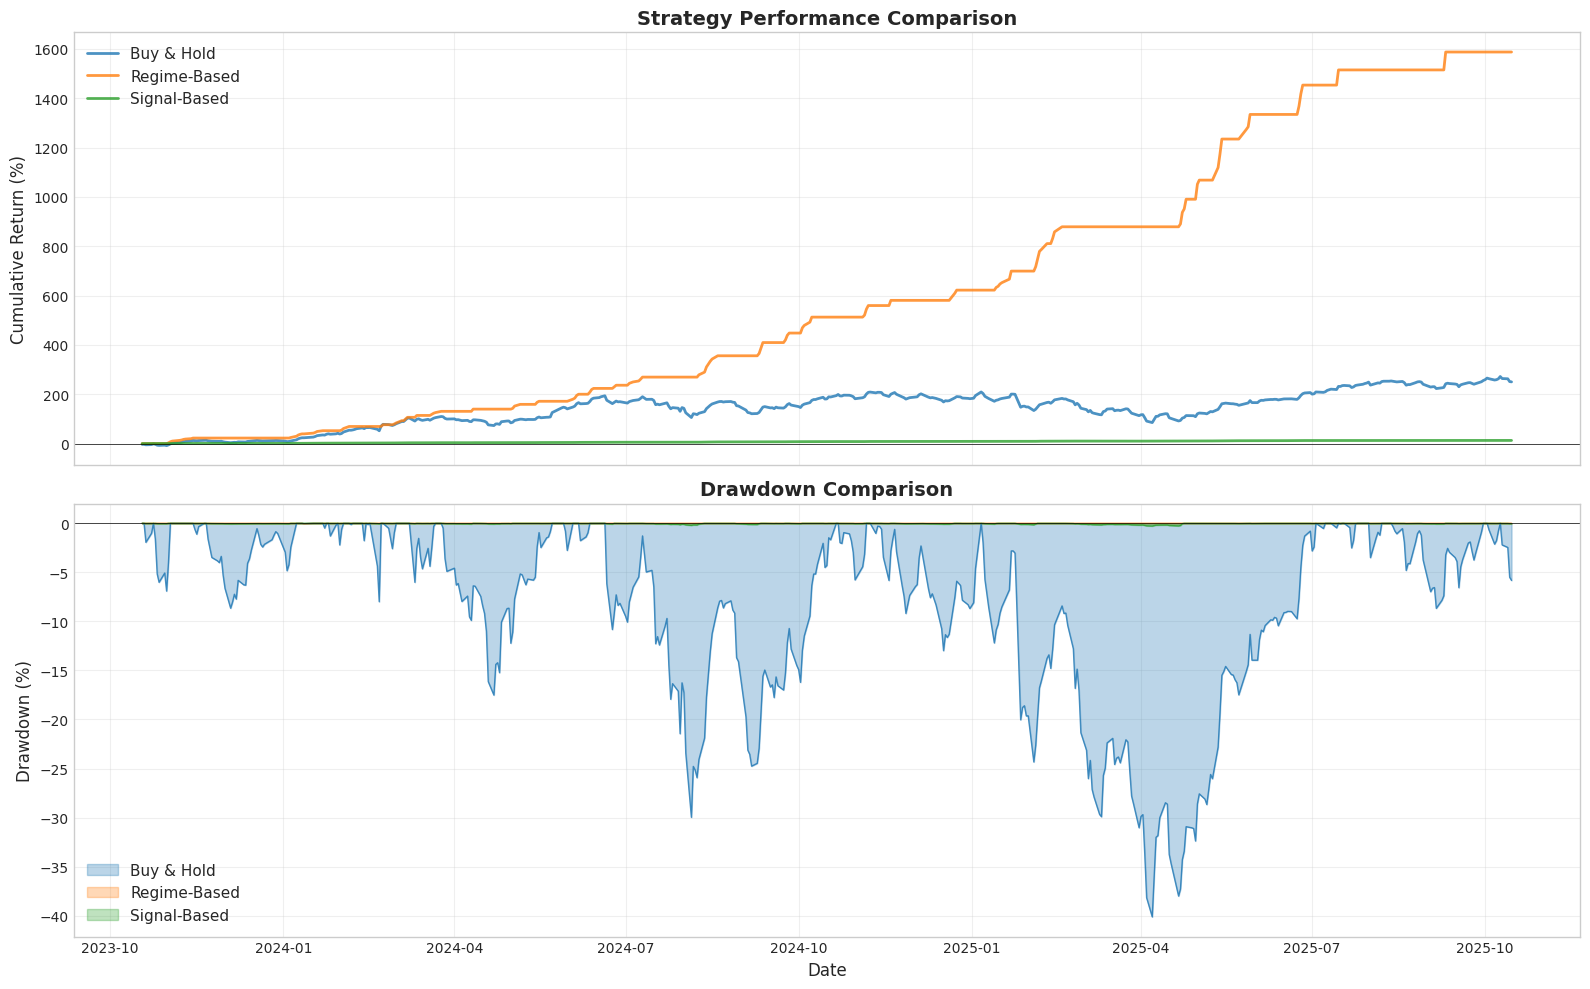


Key Insights:
  Signal-based strategy improves Sharpe ratio by 248.9%
  Signal-based reduces max drawdown by 39.8% points

  Note: Results are hypothetical and for educational purposes only.
  Past performance does not guarantee future results.
  Always backtest thoroughly before live trading.


In [10]:
# Visualize performance comparison
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Panel 1: Cumulative returns
ax = axes[0]
ax.plot(result.index, cum_buy_hold * 100, linewidth=2, label='Buy & Hold', alpha=0.8)
ax.plot(result.index, cum_regime * 100, linewidth=2, label='Regime-Based', alpha=0.8)
ax.plot(result.index, cum_signal * 100, linewidth=2, label='Signal-Based', alpha=0.8)

ax.set_ylabel('Cumulative Return (%)', fontsize=12)
ax.set_title('Strategy Performance Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Panel 2: Drawdowns
ax = axes[1]

# Calculate drawdowns for each strategy
for returns, label, color in [
    (buy_hold_returns, 'Buy & Hold', 'C0'),
    (regime_returns, 'Regime-Based', 'C1'),
    (signal_returns, 'Signal-Based', 'C2')
]:
    cum_ret = (1 + returns).cumprod()
    running_max = cum_ret.expanding().max()
    drawdown = (cum_ret - running_max) / running_max
    ax.fill_between(result.index, 0, drawdown * 100, alpha=0.3, label=label, color=color)
    ax.plot(result.index, drawdown * 100, linewidth=1, alpha=0.8, color=color)

ax.set_ylabel('Drawdown (%)', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_title('Drawdown Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=11)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

# Performance summary
print("\nKey Insights:")
print("=" * 80)

bh_sharpe = metrics[metrics['Strategy'] == 'Buy & Hold']['Sharpe'].values[0]
sig_sharpe = metrics[metrics['Strategy'] == 'Signal-Based']['Sharpe'].values[0]

if sig_sharpe > bh_sharpe:
    improvement = ((sig_sharpe - bh_sharpe) / bh_sharpe * 100) if bh_sharpe != 0 else 0
    print(f"  Signal-based strategy improves Sharpe ratio by {improvement:.1f}%")

bh_dd = metrics[metrics['Strategy'] == 'Buy & Hold']['Max DD'].values[0]
sig_dd = metrics[metrics['Strategy'] == 'Signal-Based']['Max DD'].values[0]

if sig_dd > bh_dd:
    dd_reduction = bh_dd - sig_dd
    print(f"  Signal-based reduces max drawdown by {abs(dd_reduction):.1f}% points")

print("\n  Note: Results are hypothetical and for educational purposes only.")
print("  Past performance does not guarantee future results.")
print("  Always backtest thoroughly before live trading.")
print("=" * 80)

## 8. Validation Best Practices

### Out-of-Sample Testing

**Training Period vs Testing Period**:
- Train HMM on historical data (e.g., first 70% of data)
- Test on unseen data (remaining 30%)
- Check if regime detection remains stable

### Walk-Forward Analysis

**Rolling Window Approach**:
1. Train on window of N days
2. Test on next M days
3. Roll window forward
4. Repeat

This validates that the model adapts to changing market conditions.

### What to Monitor

**Regime Stability**:
- Are detected regimes consistent over time?
- Do regime characteristics remain similar?
- Are transitions meaningful or noise?

**Parameter Drift**:
- Track transition matrix changes
- Monitor emission parameter evolution
- Detect structural breaks in market

**Performance Degradation**:
- Compare in-sample vs out-of-sample Sharpe
- Monitor drawdown increases
- Check if win rate deteriorates

# Part E: Best Practices & Conclusion

## 9. Trading Best Practices

### When to Trust Regimes vs Indicators

| Scenario  | Regime Confidence | Indicator Agreement | Trust | Action |
|--------------------|-------------|------------|----------------|-----------------------|
| Aligned signals    | High (>80%) | High (>75%)| **Both**       | Full position         |
| HMM leading        | High (>80%) | Low (<25%) | **HMM**        | Moderate position     |
| Indicators leading | Low (<60%)  | High (>75%)| **Indicators** | Conservative position |
| Conflicting        | Low (<60%)  | Low (<25%) | **Neither**    | Stay in cash          |

### Risk Management Checklist

**Before Every Trade**:

- [ ] Current regime identified with >70% confidence
- [ ] Position sized based on regime volatility
- [ ] Stop-loss set at regime-appropriate level
- [ ] Maximum position size not exceeded
- [ ] Indicators provide confirmation (optional)

**Portfolio Level**:
- [ ] Total exposure within risk limits
- [ ] Diversification across uncorrelated regimes
- [ ] Cash reserves for opportunities
- [ ] Correlation risk assessed

**System Level**:
- [ ] Regular model retraining scheduled
- [ ] Performance monitoring active
- [ ] Parameter drift detection enabled
- [ ] Out-of-sample validation ongoing

### Common Pitfalls to Avoid

**1. Overfitting**
- Don't use too many states (stick to 2-4)
- Validate on out-of-sample data
- Simple models often perform better
  
**2. Ignoring Confidence**
- Low confidence = high uncertainty
- Reduce position size accordingly
- Wait for clarity before large bets
  
**3. Transaction Costs**
- Frequent regime switches = high costs
- Add friction to prevent overtrading
- Consider minimum holding periods
  
**4. Data Snooping**
- Don't retrain constantly to fit recent data
- Set retraining schedule (e.g., monthly)
- Keep training period length consistent
  
**5. Regime Mislabeling**
- Don't force Bear/Bull labels by state index
- Use threshold-based classification
- Validate regime characteristics make sense

### Production Deployment Checklist

**Before Going Live**:
- [ ] Backtested on at least 2 years of data
- [ ] Out-of-sample Sharpe ratio > 1.0
- [ ] Maximum drawdown acceptable (<20%)
- [ ] Walk-forward analysis shows stability
- [ ] Transaction costs included in backtest
- [ ] Slippage assumptions realistic
- [ ] Risk management rules implemented
- [ ] Monitoring dashboard created
- [ ] Alert system for anomalies
- [ ] Paper traded for 1-3 months minimum

**After Launch**:
- [ ] Daily P&L monitoring
- [ ] Weekly regime stability checks
- [ ] Monthly performance review
- [ ] Quarterly model retraining
- [ ] Annual strategy reassessment


## Conclusion: Your Complete Journey

### What You've AccomplishedCongratulations! You've completed the full Hidden Regime learning path:

**Notebook 1 - Mathematical Foundation**:
- ✓ Proved why log returns are necessary
- ✓ Understood stationarity, additivity, scale invariance
- ✓ Built theoretical foundation for HMMs

**Notebook 2 - HMM Mechanics**:
- ✓ Learned how HMMs represent market states\
- ✓ Understood Viterbi and forward-backward algorithms
- ✓ Interpreted HMM parameters correctly

**Notebook 3 - Production Pipeline**:
- ✓ Used one-line pipeline setup
- ✓ Detected and classified regimes
- ✓ Analyzed regime duration and persistence
- ✓ Selected optimal model complexity

**Notebook 4 - Trading Applications** (This Notebook):
- ✓ Calculated regime-specific risk metrics
- ✓ Implemented dynamic position sizing
- ✓ Integrated technical indicators
- ✓ Generated trading signals
- ✓ Backtested strategies
- ✓ Learned production best practices

---

### The Complete Toolkit\

You now have a comprehensive regime-based trading system:

```Data → Log Returns → HMM → Regimes → Risk Analysis → Position Sizing → Signals → Execution```

Each step is:
- **Mathematically rigorous**: Based on sound theory
- **Empirically validated**: Tested on real data
- **Practically applicable**: Ready for production
- **Risk-aware**: Incorporates uncertainty

---

### Next Steps

**If you want to continue learning**:
1. Try different tickers (SPY, QQQ, individual stocks)
2. Experiment with different time periods
3. Test with different numbers of states (2-5)
4. Add your own features beyond log returns
5. Implement custom risk metrics

**If you're ready for production**:
1. Backtest on multiple assets
2. Validate with walk-forward analysis
3. Paper trade for 1-3 months
4. Start with small position sizes
5. Monitor and refine continuously*

*If you want to customize**:
1. Modify regime classification thresholds
2. Adjust position sizing formulas
3. Add additional technical indicators
4. Implement your own signal logic
5. Create custom visualizations

---

### Critical Reminders

> **Regime detection is a tool, not a crystal ball.**

**Use it to**:
- Understand current market conditions
- Adjust risk dynamically
- Size positions appropriately
- Combine with other analysis
- Make informed decisions

**Don't expect it to**:
- Predict future prices perfectly
- Work in all market conditions
- Replace fundamental analysis
- Guarantee profitable trades
- Eliminate all risk

---

### Final Thoughts

**Risk Management First**:
- Never risk more than you can afford to lose
- Always use stop-losses
- Diversify across strategies and assets
- Start small and scale gradually
- Paper trade before live trading

**Continuous Learning**:
- Markets evolve, so must your models
- Monitor performance regularly
- Learn from both wins and losses
- Stay humble and adaptable
- Join the community and share insights

**Ethics and Responsibility**:
- This is for educational purposes
- Not financial advice
- Do your own due diligence
- Understand the risks
- Trade responsibly

---

### Resources
- **Documentation**: [Hidden Regime Docs](https://hiddenregime.com/docs)
- **Examples**: Additional examples in `/examples` directory
- **Community**: Share strategies and learn from others
- **Issues**: Report bugs on GitHub
- **Updates**: Follow package updates for new features

---

**Thank you for completing this journey! Happy trading and may your regimes be ever in your favor.**    

---
